<a href="https://colab.research.google.com/github/Albertyao1993/Albertyao1993.github.io/blob/master/DistilBert_CN1_Multi_Classification_semantic_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 简介
- distil bert
- no cross validation
- semantic loss

In [1]:
!pip install transformers Ipython


     |████████████████████████████████| 3.4 MB 14.0 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 895 kB 61.1 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
import transformers

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from torch.nn.utils import clip_grad_norm_
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import defaultdict

RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCH = 20
LR = 1e-4
WEIGHT = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'distilbert-base-uncased'

class CN1_Dataset(Dataset):

    def __init__(self,data, max_len=256):
        self.data = data
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_len = max_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row_data = self.data.iloc[idx]
        content = row_data['content']
        label = row_data[-3:]

        encoding = self.tokenizer(
            content,
            padding='max_length', 
            truncation=True,
            max_length=self.max_len, 
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float32)
        }

def CreateDataloader(ds, batch_size=16, drop_last=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        drop_last=drop_last
    )

def semantic_loss(preds, batch_size, device):

    # normalized_preds = torch.sigmoid(preds).to(device)
    # print(normalized_preds)
    wmc_tmp = torch.zeros(batch_size).to(device)
    for i in range(3):
        one = torch.concat(
            [torch.concat([torch.ones([batch_size,i]), torch.zeros([batch_size, 1])], axis=1),
             torch.ones([batch_size, 3-i-1])], axis=1).to(device)
        # normalized_preds = torch.stack((normalized_preds,normalized_preds,normalized_preds),1)
        # print(normalized_preds)
        # break
        # print(one - normalized_preds)
        # print('--------------------------')
        wmc_tmp += torch.prod(one-preds, axis=1).to(device)
        # wmc_tmp += torch.prod(one-normalized_preds, axis=1).to(device)
        # print(torch.log(torch.abs(wmc_tmp)))
        log_wmc = (torch.abs(wmc_tmp)).to(device)
        sl = torch.mean(torch.sum(log_wmc)).to(device)
    return sl

'''
load data
'''
df = pd.read_csv('/content/drive/Othercomputers/我的 MacBook Pro (1)/Documents/GitHub/neural_symbolic_FG/training/kn1_data.csv')
df_data = pd.DataFrame()
df_data['content'] = df['reference_answer'] + df['response']
one_hot_labels = pd.get_dummies(df['verification'])
df_data = pd.concat([df_data, one_hot_labels], axis=1)

'''
create train and val dataset and dataloader
'''
df_train,df_val = train_test_split(df_data, random_state=RANDOM_STATE, test_size=0.15)
ds_train = CN1_Dataset(df_train)
ds_val = CN1_Dataset(df_val)

dl_train = CreateDataloader(ds_train,batch_size=BATCH_SIZE)
dl_val = CreateDataloader(ds_val, batch_size=BATCH_SIZE)

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                            num_labels=3,
                                                            output_hidden_states=False,
                                                            output_attentions=False)
model.to(DEVICE)
# criterion = nn.CrossEntropyLoss().to(DEVICE)
criterion = nn.BCELoss().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LR )

history = defaultdict(list)

for epoch in range(EPOCH):


    model.train()
    train_losses = []
    train_correct_preds = 0

    for data in dl_train:
        input_ids = data['input_ids'].squeeze(1).to(DEVICE)
        attention_mask = data['attention_mask'].squeeze(1).to(DEVICE)
        label = data['label'].to(DEVICE)

        output = model(input_ids, attention_mask)
        # output = softmax(output.logits)
        output = torch.sigmoid(output.logits)

        train_loss = -WEIGHT * semantic_loss(output, output.shape[0], DEVICE) + criterion(output, label) 
        train_losses.append(train_loss.item())
        train_correct_preds += torch.sum(torch.argmax(output, dim=1) == torch.argmax(label, dim=1))
        train_acc = train_correct_preds / len(ds_train)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()


    model.eval()
    val_losses = []
    val_correct_preds = 0
    with torch.no_grad():
      for data in dl_val:
          input_ids = data['input_ids'].squeeze(1).to(DEVICE)
          attention_mask = data['attention_mask'].squeeze(1).to(DEVICE)
          label = data['label'].to(DEVICE)

          output = model(input_ids, attention_mask)
          # output = softmax(output.logits)
          output = torch.sigmoid(output.logits)


          val_loss = -WEIGHT * semantic_loss(output, output.shape[0], DEVICE) + criterion(output, label) 
          val_losses.append(val_loss.item())
          val_correct_preds += torch.sum(torch.argmax(output, dim=1) == torch.argmax(label, dim=1))
          val_acc = val_correct_preds / len(ds_val)
    
    
    history['train_loss'].append(np.mean(train_losses))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(np.mean(val_losses))
    history['val_acc'].append(val_acc)

    print('#'*50)
    print(f'run {epoch+1} of {EPOCH}')
    print(f'train loss: {np.mean(train_losses)}, train acc: {train_acc}')
    print(f'val loss: {np.mean(val_losses)}, val acc: {val_acc}')





Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

##################################################
run 1 of 20
train loss: 0.518294308334589, train acc: 0.5964912176132202
val loss: 0.49219984241894316, val acc: 0.5675675868988037
##################################################
run 2 of 20
train loss: 0.4243898898363113, train acc: 0.6610845327377319
val loss: 0.4315850351537977, val acc: 0.6486486792564392
##################################################
run 3 of 20
train loss: 0.35879192147403954, train acc: 0.7376395463943481
val loss: 0.38811499731881277, val acc: 0.7342342734336853
##################################################
run 4 of 20
train loss: 0.31833580955863, train acc: 0.7743221521377563
val loss: 0.36940250226429533, val acc: 0.7207207679748535
##################################################
run 5 of 20
train loss: 0.2825639302842319, train acc: 0.7990430593490601
val loss: 0.3803987673350743, val acc: 0.7432432770729065
##################################################
run 6 of 20
train loss: 0.2454569

# Plot train loss and accuracy


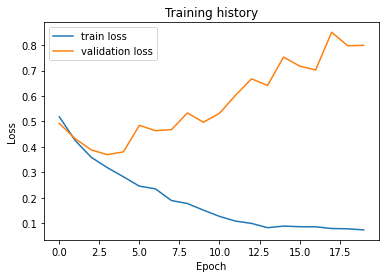

In [16]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1])
plt.show()

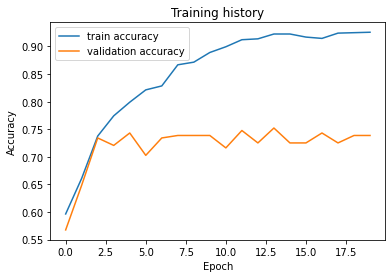

In [17]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1])
plt.show()